Creating Linnaeus-5 dataset from directory

In [1]:
from google.colab import drive ;
drive.mount('/content/drive') ;

Mounted at /content/drive


In [2]:

import os ;
import numpy as np ;
from os import listdir ;
import matplotlib.image as mpimg ;
import matplotlib.pyplot as plt ;

firstLevel = ['test', 'train'] ;
secondLevel = ['berry', 'bird', 'dog', 'flower', 'other'] ;
sourceDirectory = '/content/drive/MyDrive/Linnaeus-5/' ;

In [3]:
imageCounter = 0 ;
for i in firstLevel:
  for j in secondLevel:
    directory = sourceDirectory + i + '/' + j ;
    for images in os.listdir(directory):
      if(images.endswith(".jpg")):
        imageCounter += 1 ;
print('Total Images: ',  imageCounter) ;
print('Images Per Class: ', imageCounter/5.0) ;

Total Images:  8000
Images Per Class:  1600.0


In [4]:
xtrain = [] ; ytrain = [] ;
xtest = [] ; ytest = [] ;

In [5]:
# I tried to make a subdirectory extractor
for i in firstLevel:
  for j in secondLevel:
    directory = sourceDirectory + i + '/' + j ;
    for image in os.listdir(directory):
      if(image.endswith(".jpg")):
        img = mpimg.imread(directory + '/' + image) ;
        img = img/255.0 ;
        if i == 'test':
          ytest.append(secondLevel.index(j)) ;
          xtest.append(img) ;
        else:
          ytrain.append(secondLevel.index(j)) ;
          xtrain.append(img) ;

In [6]:
xtrain = np.array(xtrain, dtype='float32') ; ytrain = np.array(ytrain) ;
xtest = np.array(xtest, dtype='float32') ; ytest = np.array(ytest) ;

In [7]:
print('Training Images: ', xtrain.shape, ytrain.shape) ;
print('Testing Images: ', xtest.shape, ytest.shape) ;

Training Images:  (6000, 128, 128, 3) (6000,)
Testing Images:  (2000, 128, 128, 3) (2000,)


In [8]:
import tensorflow as tf ;
from tensorflow.keras.utils import plot_model ;
from tensorflow.keras import layers, models, losses, optimizers ;

In [9]:
np.random.seed(123) ;
tf.random.set_seed(123) ;
device = tf.test.gpu_device_name() ;
device

'/device:GPU:0'

In [10]:
# Down sampler CNN network
def downCNN(filters, kernel_size, batchNormalization = True):
    downsampler = models.Sequential() ;
    downsampler.add(layers.Conv2D(filters, kernel_size, padding = 'same', strides = 2)) ;
    if batchNormalization: downsampler.add(layers.BatchNormalization()) ;
    downsampler.add(layers.LeakyReLU()) ;
    return downsampler ;

In [11]:
# Up sampler CNN network
def upCNN(filters, kernel_size, dropOut = True):
    upsampler = models.Sequential() ;
    upsampler.add(layers.Conv2DTranspose(filters, kernel_size, padding = 'same', strides = 2)) ;
    if dropOut: upsampler.add(layers.Dropout(0.2)) ;
    upsampler.add(layers.ReLU()) ;
    return upsampler ;

This might look familiar because I just used my autoencoder as the generator for GAN !

In [12]:
def Generator():
    # Random noise corresponding to the image dimensions
    noise = layers.Input(shape = [128,128,1]) ;

    # Feed it to an encoder network for downsampling to a latent vector
    d1 = downCNN(128,(3,3),False)(noise) ;
    d2 = downCNN(128,(3,3),False)(d1) ;
    d3 = downCNN(256,(3,3),True)(d2) ;
    d4 = downCNN(512,(3,3),True)(d3) ;

    # Decode the latent vector to upscale into large image matrix
    u1 = layers.Conv2D(512, kernel_size=(3,3) , strides=1 , activation='tanh', padding='same')(d4) ; # Bottleneck
    u1 = layers.concatenate([u1,d4]) ;
    u2 = upCNN(256,(3,3),False)(u1) ;
    u2 = layers.concatenate([u2,d3]) ;
    u3 = upCNN(128,(3,3),False)(u2) ;
    u3 = layers.concatenate([u3,d2]) ;
    u4 = upCNN(128,(3,3),False)(u3) ;
    u4 = layers.concatenate([u4,d1]) ;
    u5 = upCNN(3,(3,3),False)(u4) ;
    u5 = layers.concatenate([u5,noise]) ;

    # Generate colored images with final convolution
    output = layers.Conv2D(3, (2,2), strides = 1, padding = 'same')(u5) ;
    return models.Model(inputs=noise, outputs=output) ;

This will even look more familiar because it is just a CNN used for the discriminator of GAN !

In [13]:
def Discriminator():
    # Input grayscale images of dimensions 128*128
    image = layers.Input(shape = [128,128,3]) ;

    # Increase receptive field by choosing more filters and larger kernels
    c1 = downCNN(128,(7,7),False)(image) ;
    c2 = downCNN(256,(5,5),False)(c1) ;
    c3 = downCNN(512,(3,3),True)(c2) ;
    c4 = downCNN(512,(3,3),True)(c3) ;

    # ANN for CNN discriminator logic
    c4 = layers.Flatten()(c4) ;
    c4 = layers.Dense(512, activation=layers.ReLU())(c4) ;
    c4 = layers.Dense(128, activation=layers.ReLU())(c4) ;
    c4 = layers.Dense(32, activation=layers.ReLU())(c4) ;

    output = layers.Dense(1, activation='sigmoid')(c4) ;
    return models.Model(inputs=image, outputs=output) ;

In [14]:
def rgb2gray(dimensions, rgb):
    gray = np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140]) ;
    return gray ;

It's time to check how the generator and discriminator works now. This grayscale colormap is needed in image plot due to its basic interpolation usage in matplotlib imshow() function. It isn't needed if I don't reduce grayscale image to single channel but rather keep all 3 channels equal and intact ! The discriminator just gives a probability of how real (accurate) the colored image is !

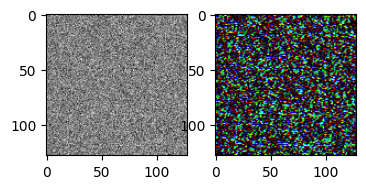

In [15]:
# Testing the generator with a noise image
generator = Generator() ;
noise = tf.random.normal([1, 128, 128, 1]) ;
generation = generator(noise, training=False) ;
figure, axes = plt.subplots(nrows=1, ncols=2, figsize=(4,2)) ;
axes[0].imshow(noise[0, :], cmap='gray') ;
axes[1].imshow(generation[0, :]) ;

In [16]:
discriminator = Discriminator() ;
out = discriminator(generation, training=False) ;
print(tf.reshape(out, -1)) ;

tf.Tensor([0.49428293], shape=(1,), dtype=float32)


Loss functions

In [17]:
def generator_loss(fake_output , real_y):
    real_y = tf.cast(real_y, 'float32') ;
    mse = losses.MeanSquaredError() ; # Trust me - we need to call objects and can't use them as functions else it won't work as per TF library !
    return mse(fake_output, real_y) ;

In [18]:
tf.print(generator_loss(generation, noise))

0.821398139


In [19]:
def discriminator_loss(real, fake):
    # This list will store log losses for discriminator - I wanted to store real, fake and total loss together !
    # The small random value addition in sample labels generates noisy labels to prevent early killing of GAN procedure !
    loss = [] ;
    entropy = losses.BinaryCrossentropy() ;
    # Real Loss
    loss.append(entropy(tf.ones_like(real) - tf.random.uniform(shape=real.shape, maxval=0.1) , real)) ;
    # Fake Loss
    loss.append(entropy(tf.zeros_like(fake) + tf.random.uniform(shape=fake.shape, maxval=0.1), fake)) ;
    # Total Loss
    loss.append(loss[0]+loss[1]) ;
    return loss ;

In [20]:
generator = Generator() ;
discriminator = Discriminator() ;
generatorOpt = optimizers.Adam(learning_rate = 0.001) ;
discriminatorOpt = optimizers.Adam(learning_rate = 0.0005) ; # Half the rate of generator (Rule of Thumb - they say ?!)

Setting up a step computation phase for GAN where both generator and discriminator are incorporated together !

In [21]:
# I can use them for displaying per-iteration loss but it will be too much to write to output buffer !
#tf.keras.backend.print_tensor(generatorLoss, message='Generator loss: ') ;
#tf.keras.backend.print_tensor(discriminatorLoss[0], message='Real loss: ') ;
#tf.keras.backend.print_tensor(discriminatorLoss[1], message='Fake loss: ') ;
#tf.keras.backend.print_tensor(discriminatorLoss[2], message='Discriminator loss: ') ;

In [22]:
@tf.function
def stochGradStepTraining(input_x, real_y):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate an image that is supposedly colored -> G(x)
        generatedImage = generator(input_x, training=True) ;
        # Probability that the given image colored is real (i.e. well colored) -> D(x)
        real_output = discriminator(real_y, training=True) ;
        # Probability that the given image is the one generated (i.e. not the original one or accurate to it) -> D(G(x))
        generated_output = discriminator(generatedImage, training=True) ;
        generatorLoss = generator_loss(generatedImage , real_y) ;
        discriminatorLoss = discriminator_loss(real_output, generated_output) ;

    # Compute the gradients
    gradientsForGenerator = gen_tape.gradient(generatorLoss, generator.trainable_variables) ;
    gradientsForDiscriminator = disc_tape.gradient(discriminatorLoss[2], discriminator.trainable_variables) ;
    # Optimize with Adam
    generatorOpt.apply_gradients(zip(gradientsForGenerator, generator.trainable_variables)) ;
    discriminatorOpt.apply_gradients(zip(gradientsForDiscriminator, discriminator.trainable_variables)) ;
    return [generatorLoss, discriminatorLoss[0], discriminatorLoss[1], discriminatorLoss[2]] ;


Dataset Analysis & Preprocessing

In [23]:
def showImage(data, index, label=None, cmap=None):
  plt.figure(figsize=(0.5, 0.5)) ;
  plt.imshow(data[index], cmap=cmap) ;
  if label != None:
    plt.xlabel(labels[label[index]]) ;

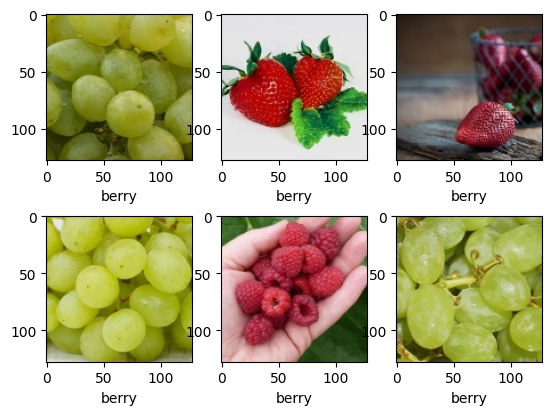

In [24]:
figure, axes = plt.subplots(2, 3) ;
for i in range(6):
    axes[int(i/3)][int(i%3)].imshow(xtrain[i]) ;
    axes[int(i/3)][int(i%3)].set_xlabel(secondLevel[ytrain[i]]) ;
plt.show() ;

In [25]:
xtrainG = np.zeros(shape=(xtrain.shape[0],128,128), dtype=np.float32) ;
for i in range(xtrain.shape[0]):
  xtrainG[i] = rgb2gray(128, xtrain[i]) ;
xtrainG = xtrainG.reshape((xtrainG.shape[0],128,128,1)) ;

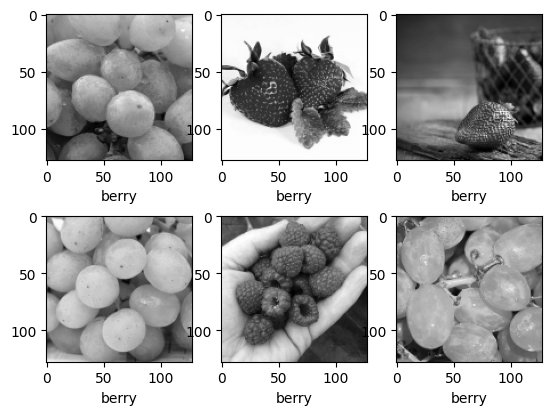

In [26]:
figure, axes = plt.subplots(2, 3) ;
for i in range(6):
    axes[int(i/3)][int(i%3)].imshow(xtrainG[i], cmap='gray') ;
    axes[int(i/3)][int(i%3)].set_xlabel(secondLevel[ytrain[i]]) ;
plt.show() ;

In [27]:
dataset = tf.data.Dataset.from_tensor_slices((xtrainG, xtrain)) ;
dataset = dataset.batch(batch_size=50) ;

Model Training & Evaluation

In [28]:
# !!! WARNING: This optimizes CPU performance - DON'T USE THIS WHEN GPU IS ENABLED !!! (Learnt the hard way!)
# tf.config.run_functions_eagerly(True) ; #  IT ENABLES CONVOLUTION LAYER TO FUNCTION EARLY CAUSING ISSUES IN TENSORS IF GPU IS USED
# tf.data.experimental.enable_debug_mode() ; # IT DISABLES PARALLELISM AND FORCES SEQUENTIAL OPERATION

In [29]:
epochs = 200 ;
lossHistory = [] ;
for epoch in range(epochs):
    print(f'Epoch {epoch+1}:') ;
    for (x, y) in dataset:
        loss = stochGradStepTraining(x,y) ;
    lossHistory.append(loss) ;
    print(f'Generator loss: {loss[0]}') ;
    print(f'Discriminator loss: {loss[3]} [Real: {loss[1]} | Fake: {loss[2]}]') ;

Epoch 1:
Generator loss: 0.020585045218467712
Discriminator loss: 0.37981629371643066 [Real: 0.20200294256210327 | Fake: 0.1778133362531662]
Epoch 2:
Generator loss: 0.015051210299134254
Discriminator loss: 0.4001544713973999 [Real: 0.2088700830936432 | Fake: 0.1912844032049179]
Epoch 3:
Generator loss: 0.013771320693194866
Discriminator loss: 0.41411954164505005 [Real: 0.21118976175785065 | Fake: 0.2029297649860382]
Epoch 4:
Generator loss: 0.013197563588619232
Discriminator loss: 0.38894057273864746 [Real: 0.18818889558315277 | Fake: 0.20075169205665588]
Epoch 5:
Generator loss: 0.012730903923511505
Discriminator loss: 0.4229750633239746 [Real: 0.21655884385108948 | Fake: 0.20641620457172394]
Epoch 6:
Generator loss: 0.011634062975645065
Discriminator loss: 0.4171074628829956 [Real: 0.20885306596755981 | Fake: 0.2082543969154358]
Epoch 7:
Generator loss: 0.010998554527759552
Discriminator loss: 0.4125017821788788 [Real: 0.1942409723997116 | Fake: 0.21826080977916718]
Epoch 8:
Generat

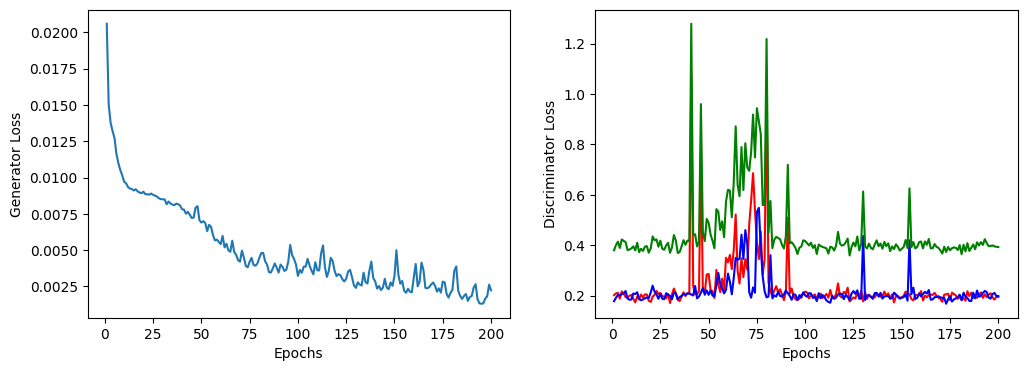

In [30]:
figure, axes = plt.subplots(1,2, figsize=(12,4)) ;
epochs = np.arange(1,201) ;
lossHistory = np.array(lossHistory) ;
axes[0].plot(epochs, lossHistory[:,0]) ;
axes[0].set_xlabel('Epochs') ;
axes[0].set_ylabel('Generator Loss') ;
axes[1].plot(epochs, lossHistory[:,1], color='red') ;
axes[1].plot(epochs, lossHistory[:,2], color='blue') ;
axes[1].plot(epochs, lossHistory[:,3], color='green') ;
axes[1].set_xlabel('Epochs') ;
axes[1].set_ylabel('Discriminator Loss') ;
plt.show() ;

In [31]:
!pip install pyyaml h5py
generator.save('generatorGAN_linnaeus5.h5') ;
generator.save('generatorGAN_linnaeus5.keras') ;

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [32]:
xtestG = np.zeros((xtest.shape[0],128,128)) ;
for i in range(xtest.shape[0]):
  xtestG[i] = rgb2gray(128, xtest[i]) ;
xtestG = xtestG.reshape((xtestG.shape[0],128,128,1)) ;

Model Prediction & Output Overview

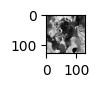

In [33]:
showImage(xtestG, 0, cmap='gray') ;

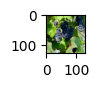

In [34]:
showImage(xtest, 0) ;

In [35]:
coloredOutput = generator(xtestG[0].reshape(1,128,128,1)) ;
coloredOutput

<tf.Tensor: shape=(1, 128, 128, 3), dtype=float32, numpy=
array([[[[0.2838719 , 0.27002   , 0.20964186],
         [0.3075129 , 0.2889737 , 0.22170202],
         [0.23011263, 0.20482162, 0.1664796 ],
         ...,
         [0.18311559, 0.30798376, 0.34261286],
         [0.24106205, 0.2952045 , 0.30954218],
         [0.29981554, 0.30475104, 0.16699888]],

        [[0.29714736, 0.2876714 , 0.22788621],
         [0.3108339 , 0.2961896 , 0.23847727],
         [0.19921377, 0.19224305, 0.15039845],
         ...,
         [0.18163311, 0.30890608, 0.33913523],
         [0.20861173, 0.30888256, 0.3148718 ],
         [0.25453117, 0.27975672, 0.13323928]],

        [[0.28699338, 0.2510533 , 0.20374463],
         [0.29568475, 0.26830623, 0.231804  ],
         [0.10425189, 0.0893584 , 0.06347351],
         ...,
         [0.17326714, 0.2993165 , 0.3360033 ],
         [0.17558375, 0.26746237, 0.32396978],
         [0.22473171, 0.23908348, 0.09935962]],

        ...,

        [[0.7979997 , 0.7492296 , 

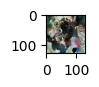

In [36]:
coloredOutput = coloredOutput.numpy().astype(np.float32) ;
showImage(coloredOutput, 0) ;

<ipython-input-37-a484f4350b28>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  figure, axes = plt.subplots(1,3, figsize=(6,1)) ;


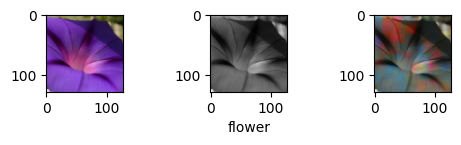

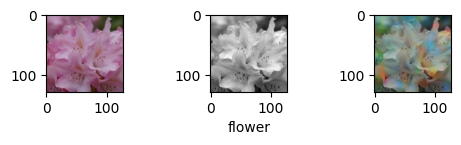

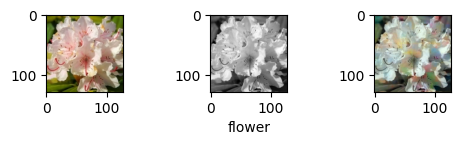

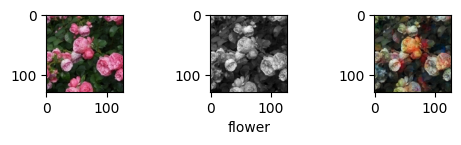

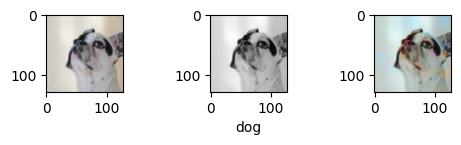

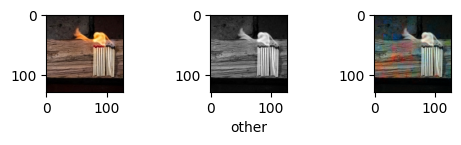

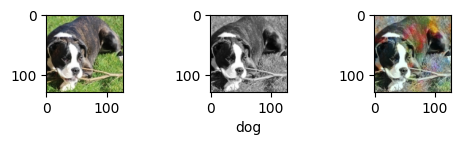

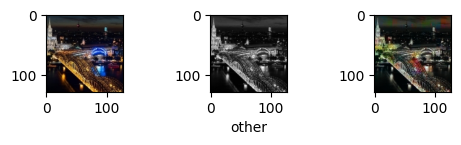

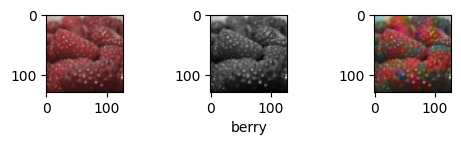

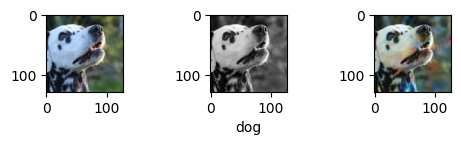

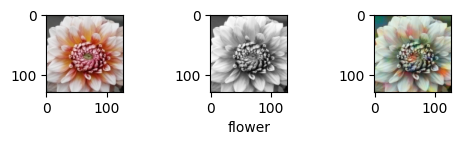

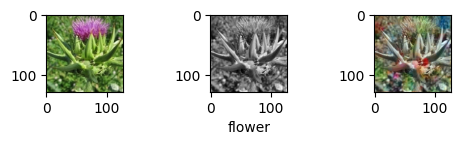

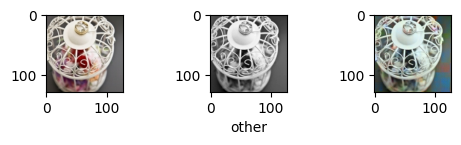

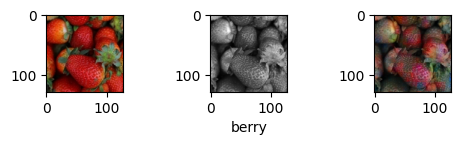

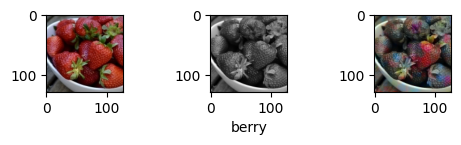

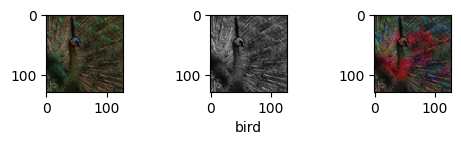

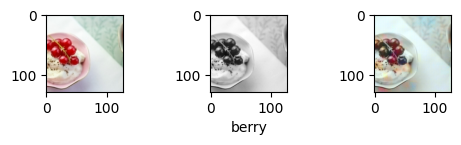

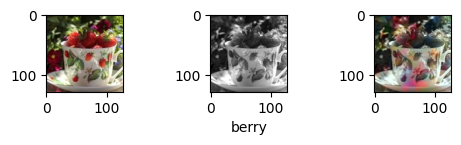

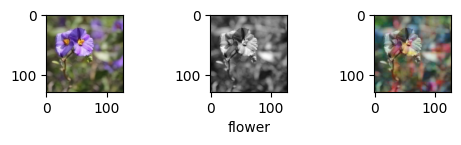

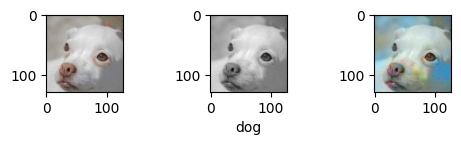

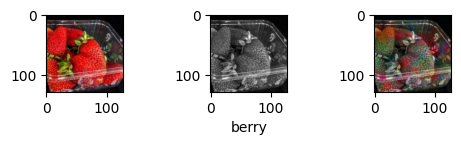

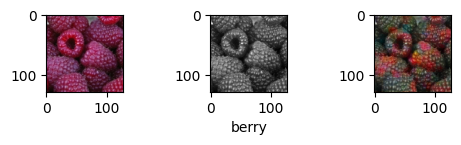

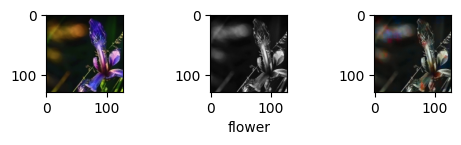

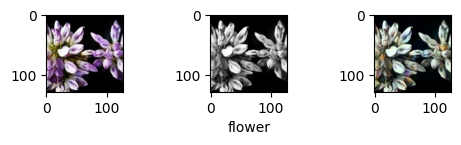

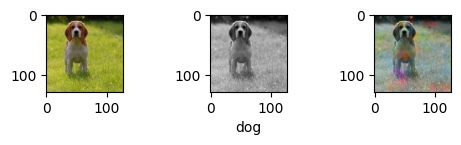

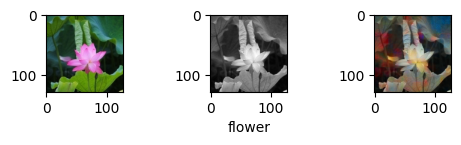

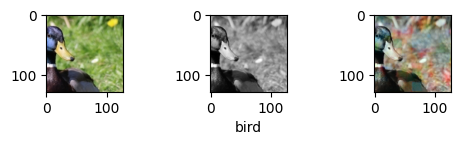

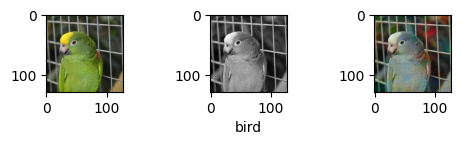

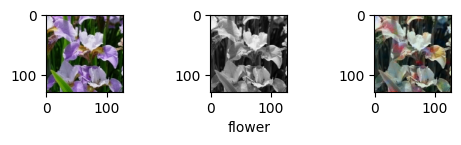

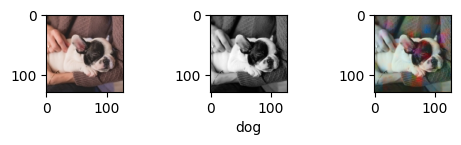

In [37]:
randomIndex = np.random.randint(low=0, high=2000, size=30) ;
for i in randomIndex:
  output = generator(xtestG[i].reshape(1,128,128,1)) ;
  output = output.numpy().astype(np.float32) ;
  figure, axes = plt.subplots(1,3, figsize=(6,1)) ;
  axes[0].imshow(xtest[i]) ;
  axes[1].imshow(xtestG[i], cmap='gray') ;
  axes[1].set_xlabel(secondLevel[ytest[i]]) ;
  axes[2].imshow(output[0]) ;
plt.show() ;